In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.special import gamma

from imripy import halo, constants as c, merger_system as ms, inspiral, waveform, detector, plot_utils, kepler
from imripy.inspiral import forces
from imripy.kepler import KeplerOrbit

#import plot_utils as pu

# Accretion Disk Modeling

In [2]:
colors = {"alpha":'blue', "beta":'orange', "dm":'red', 'vac':'gray'}

In [3]:
m1 = 1e5 * c.solar_mass_to_pc
m2 = 1. *  c.solar_mass_to_pc
D = 5e8
hs = ms.HostSystem(m1, D_l=D)

In [4]:
alpha = 0.1
f_edd = 0.1
eps = 0.1
alphaDisk = halo.AlphaDisk(m1, alpha, f_edd, eps)
betaDisk = halo.BetaDisk(m1, alpha, f_edd, eps)

### Densities

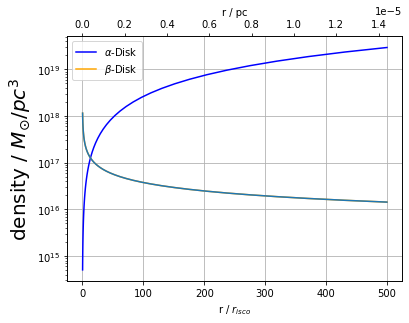

In [5]:
plt.figure(figsize=(6,6 * 6./8.))
r_grid = np.geomspace(2*m1, 500*hs.r_isco)
ax_risco = plt.gca()
ax_pc = ax_risco.twiny()
l, = ax_risco.plot(r_grid/hs.r_isco, alphaDisk.density(r_grid)/c.solar_mass_to_pc, label="$\\alpha$-Disk", color=colors["alpha"])
l, = ax_risco.plot(r_grid/hs.r_isco, betaDisk.density(r_grid)/c.solar_mass_to_pc, label="$\\beta$-Disk", color=colors["beta"])
ax_pc.plot(r_grid, betaDisk.density(r_grid)/c.solar_mass_to_pc)

ax_risco.set_yscale('log');# plt.xscale('log') 
ax_risco.set_xlabel("r / $r_{isco}$"); ax_risco.set_ylabel("density / $M_{\odot}/pc^3$", fontsize=20)
ax_pc.set_xlabel("r / pc");
ax_risco.grid(); ax_risco.legend()
#plt.savefig("plots/rho_b.pdf", bbox_inches="tight")

### Relative Strength

In [6]:
accuracy = 1e-13
opt_0 = inspiral.Classic.EvolutionOptions(dissipativeForces=[forces.GWLoss()], accuracy=accuracy, verbose=1)

gdf_alpha = forces.GasDynamicalFriction(disk =alphaDisk)
gdf_beta = forces.GasDynamicalFriction(disk=betaDisk)

opt_gdf_alpha = inspiral.Classic.EvolutionOptions(dissipativeForces=[forces.GWLoss(), gdf_alpha], 
                                             considerRelativeVelocities=True, accuracy=accuracy, verbose=1)
opt_gdf_beta = inspiral.Classic.EvolutionOptions(dissipativeForces=[forces.GWLoss(), gdf_beta], 
                                             considerRelativeVelocities=True, accuracy=accuracy, verbose=1)

gi_alpha = forces.GasInteraction(disk=alphaDisk)
gi_beta = forces.GasInteraction(disk=betaDisk)
opt_gi_alpha = inspiral.Classic.EvolutionOptions(dissipativeForces=[forces.GWLoss(), gi_alpha], 
                                             considerRelativeVelocities=False, accuracy=accuracy, verbose=1)
opt_gi_beta = inspiral.Classic.EvolutionOptions(dissipativeForces=[forces.GWLoss(), gi_beta], 
                                             considerRelativeVelocities=False, accuracy=accuracy, verbose=1)


/media/data/Documents/PhD/imripy/src/imripy/inspiral/forces.py:532: RuntimeWarning: invalid value encountered in log
  1./2. * np.log((1. + v_rel_tot/c_s)/(1. - v_rel_tot/c_s)) - v_rel_tot/c_s) # subsonic regime


(1e-19, 10.0)

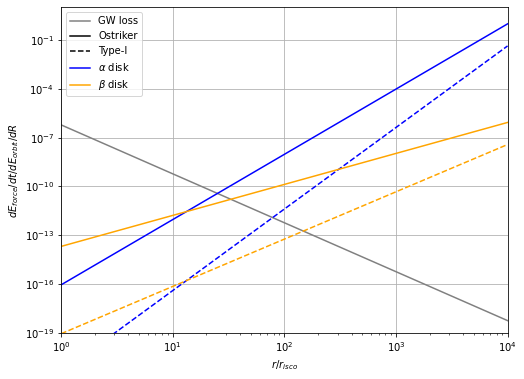

In [7]:
fig= plt.figure(figsize=(8,6))
r_grid = np.geomspace(hs.r_isco, 1e4*hs.r_isco, 100)
ax_risco = plt.gca()
#r_grid = np.geomspace(sp_0.r_isco(), 500*sp_0.r_isco())

kos = [KeplerOrbit(hs, m2, r, inclination_angle=np.pi) for r in r_grid]
ax_risco.loglog(r_grid/hs.r_isco, 
                [np.abs(forces.GWLoss().dE_dt(hs, ko, opt_0))/inspiral.Classic.dE_orbit_da(hs, ko) for ko in kos],
                label=r"GW", color=colors["vac"])

l1, = ax_risco.loglog(r_grid/hs.r_isco, 
                      [np.abs(gdf_alpha.dE_dt(hs, ko, opt=opt_gdf_alpha))/inspiral.Classic.dE_orbit_da(hs, ko) for ko in kos],
                                           label=r"Ostriker", color=colors["alpha"])
ax_risco.loglog(r_grid/hs.r_isco,
                    [np.abs(gi_alpha.dE_dt(hs, ko, opt=opt_gi_beta))/inspiral.Classic.dE_orbit_da(hs, ko) for ko in kos],
                                           label=r"Type I", color=l1.get_c(), linestyle='--')


l2, = ax_risco.loglog(r_grid/hs.r_isco, 
                      [np.abs(gdf_beta.dE_dt(hs, ko, opt=opt_gdf_beta))/inspiral.Classic.dE_orbit_da(hs, ko) for ko in kos],
                                        color=colors["beta"])
ax_risco.loglog(r_grid/hs.r_isco, 
                [np.abs(gi_beta.dE_dt(hs, ko, opt=opt_gi_beta))/inspiral.Classic.dE_orbit_da(hs, ko) for ko in kos],
                                              color=l2.get_c(), linestyle='--')

ax_risco.set_xlabel('$r/r_{isco}$'); ax_risco.set_ylabel("$dE_{force}/dt / dE_{orbit}/dR$")
explanatory_lines = [mpl.lines.Line2D([0], [0], color='gray'), 
                          mpl.lines.Line2D([0], [0], color='black'),
                          mpl.lines.Line2D([0], [0], color='black', linestyle='--'),
                          mpl.lines.Line2D([0], [0], color='blue'),
                          mpl.lines.Line2D([0], [0], color='orange')]
ax_risco.legend(explanatory_lines, ['GW loss', 'Ostriker', 'Type-I', "$\\alpha$ disk", "$\\beta$ disk"])
ax_risco.grid()

ax_risco.set_xlim(left=1, right=1e4); ax_risco.set_ylim(bottom=1e-19, top=1e1)
#plt.savefig("plots/dEdtdEdR.pdf", bbox_inches="tight")

/media/data/Documents/PhD/imripy/src/imripy/inspiral/forces.py:105: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return -(1.-e**2)**(3./2.)/2./np.pi * quad(integrand, 0., 2.*np.pi, limit = 100)[0]
/media/data/Documents/PhD/imripy/src/imripy/inspiral/forces.py:80: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return -(1.-e**2)**(3./2.)/2./np.pi * quad(integrand, 0., 2.*np.pi, limit = 100)[0]


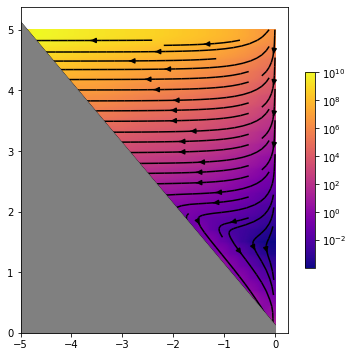

In [8]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
a_grid = np.geomspace(hs.r_isco, 1e5*hs.r_isco, 25)
e_grid = 1.-np.geomspace(1e-5, 1., 25)

ko = KeplerOrbit(hs, m2, 0., inclination_angle=np.pi)

im = plot_utils.streamline(ax, hs, opt_gdf_alpha, ko, a_grid, e_grid)
fig.colorbar(im, ax=ax, shrink=0.6)

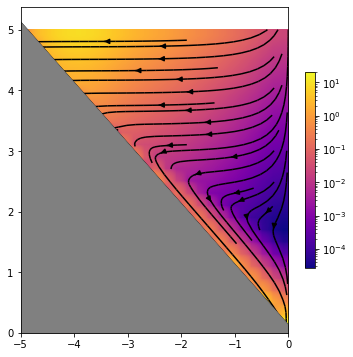

In [9]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
a_grid = np.geomspace(hs.r_isco, 1e5*hs.r_isco, 25)
e_grid = 1.-np.geomspace(1e-5, 1., 25)

ko = KeplerOrbit(hs, m2, 0., inclination_angle=np.pi)

im = plot_utils.streamline(ax, hs, opt_gdf_beta, ko, a_grid, e_grid)
fig.colorbar(im, ax=ax, shrink=0.6)

### Inspiral

In [10]:
a0 = 500. * hs.r_isco
e0 = 0.
k0 = KeplerOrbit(hs, m2, a0, e0)

In [11]:
ev_0 = inspiral.Classic.Evolve(hs, k0, opt=opt_0)

t_est = np.abs(inspiral.Classic.E_orbit(hs, k0, opt=opt_gdf_alpha) / gdf_alpha.dE_dt(hs, k0, opt=opt_gdf_alpha))
ev_alpha_gas1 = inspiral.Classic.Evolve(hs, k0, t_fin=1e8*t_est, opt=opt_gdf_alpha)

t_est = np.abs(inspiral.Classic.E_orbit(hs, k0, opt=opt_gi_alpha) / gi_alpha.dE_dt(hs, k0, opt=opt_gi_alpha))
ev_alpha_gas2 = inspiral.Classic.Evolve(hs, k0, t_fin=1e3*t_est,opt=opt_gi_alpha)

t_est = np.abs(inspiral.Classic.E_orbit(hs, k0, opt=opt_gdf_beta) / gdf_beta.dE_dt(hs, k0, opt=opt_gdf_beta))
ev_beta_gas1 = inspiral.Classic.Evolve(hs, k0, t_fin=1e5*t_est, opt=opt_gdf_beta)

t_est = np.abs(inspiral.Classic.E_orbit(hs, k0, opt=opt_gi_beta) / gi_beta.dE_dt(hs, k0, opt=opt_gi_beta))
ev_beta_gas2 = inspiral.Classic.Evolve(hs, k0, t_fin=1e3*t_est, opt=opt_gi_beta)

Evolving from  500.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, }, accuracy = 1.0e-13
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 0.1061s real time
Evolving from  500.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, GasDynamicalFriction, }, accuracy = 1.0e-13


/media/data/Documents/PhD/imripy/src/imripy/inspiral/forces.py:531: RuntimeWarning: invalid value encountered in log
  1./2. * np.log(1. - (c_s/v_rel_tot)**2) + ln_Lambda, # supersonic regime
/media/data/Documents/PhD/imripy/src/imripy/kepler.py:215: RuntimeWarning: invalid value encountered in sqrt
  v = np.sqrt(self.m_tot *(2./r - 1./self.a))
/media/data/Documents/PhD/imripy/src/imripy/kepler.py:216: RuntimeWarning: invalid value encountered in sqrt
  v_phi = r * np.sqrt(self.m_tot*self.a*(1.-self.e**2))/r**2
/media/data/Documents/PhD/imripy/src/imripy/halo/baryonic.py:425: RuntimeWarning: invalid value encountered in divide
  self.surface_density(r) / 2. / self.scale_height(r) * np.exp(-z**2 / self.scale_height(r)**2),


A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 18.6506s real time
Evolving from  500.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, GasInteraction, }, accuracy = 1.0e-13
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 0.2658s real time
Evolving from  500.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, GasDynamicalFriction, }, accuracy = 1.0e-13


/media/data/Documents/PhD/imripy/src/imripy/halo/baryonic.py:578: RuntimeWarning: invalid value encountered in divide
  self.surface_density(r) / 2. / self.scale_height(r) * np.exp(-z**2 / self.scale_height(r)**2),


A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 14.0987s real time
Evolving from  500.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, GasInteraction, }, accuracy = 1.0e-13
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 0.2387s real time


In [12]:
def preparePlots( figF, axesF, axes_ae=None, ax_m=None, axes_a=None, e_min=1e-5, f_min=1e-4, n_b_min=0.):
    figF.subplots_adjust(hspace=0, wspace=0)
    
    if not axes_ae is None:
        for ax in axes_ae:
            ax.set_xlabel('semimajor axis / $r_{isco}$')
            ax.grid()
        axes_ae[0].set_ylabel('eccentricity')

    
    if not axes_a is None:
        for ax in axes_a:
            ax.set_xlabel('time / yr')
            ax.grid()
        axes_a[0].set_ylabel('semimajor axis / $r_{isco}$')

    explanatory_lines = [mpl.lines.Line2D([0], [0], color='gray'), 
                          mpl.lines.Line2D([0], [0], color='black'),
                          mpl.lines.Line2D([0], [0], color='black', linestyle='--'),
                          mpl.lines.Line2D([0], [0], color='blue'),
                          mpl.lines.Line2D([0], [0], color='orange')]
    axes_a[-1].legend(explanatory_lines, ['vacuum', 'Ostriker', 'Type-I', "$\\alpha$ disk", "$\\beta$ disk"], 
                               loc='lower left')
    
    #axesF[0,0].set_ylabel('characteristic strain')
    axesF[0][0].set_ylabel(r'$|\Delta N|$')
    axesF[0][1].set_ylabel(r'dephasing index')
    axesF[0][2].set_ylabel(r'braking index')
    
    axesF[0][-1].set_xlabel('frequency / Hz')
    
    axesF[0][0].set_xlim(left=f_min)
    axesF[0][0].set_ylim(bottom=1., top=1e10)
    axesF[0][2].set_ylim(bottom=n_b_min, top=5)
    axesF[0][1].set_ylim(bottom=-8, top=0)

    for ax in axesF[0]:
        ax.grid()

/media/data/Documents/PhD/imripy/src/imripy/plot_utils.py:156: RuntimeWarning: divide by zero encountered in divide
  ax_di.plot(ev_1.f_gw[:stop]/c.hz_to_invpc, (ddN_df/dN * ev_1.f_gw)[:stop], color=l.get_c(), **kwargs)


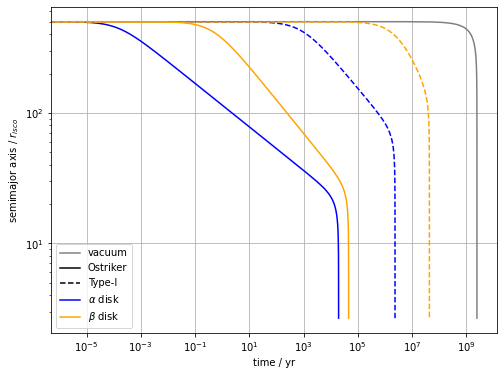

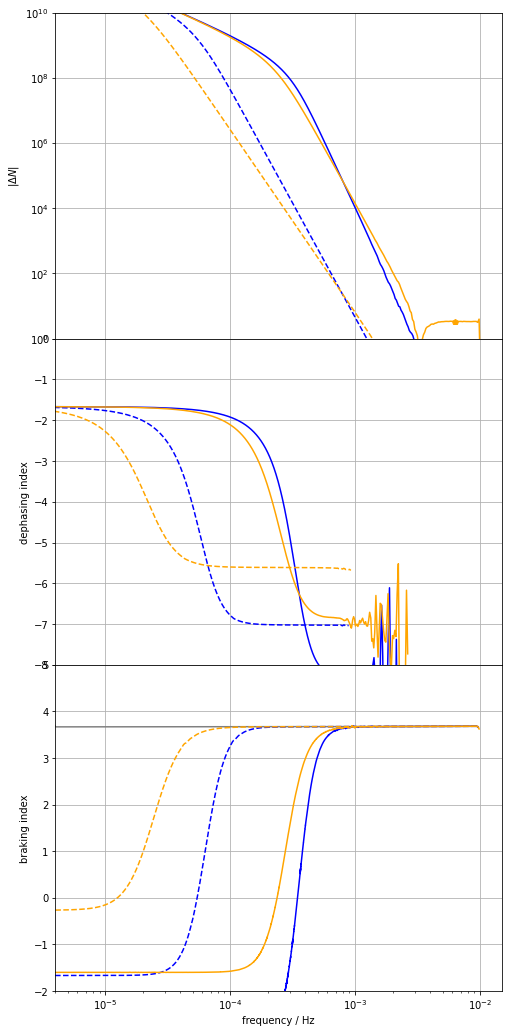

In [13]:
fig_ae, axes_ae = plt.subplots(1, 1, figsize=(8,6))
#fig_ae, axes_ae = plt.subplots(2, 1, figsize=(8,12))
fig_gw, axes_gw = plt.subplots(3, 1, figsize=(8,18), sharex='all', sharey='row')

# vacuum
l = plot_utils.plotEvolution(hs, ev_0, ax_a=axes_ae, ax_n=axes_gw[2], label='vacuum', color=colors["vac"])

# accretion disks
l = plot_utils.plotEvolution(hs, ev_alpha_gas1, ax_a=axes_ae, ax_n=axes_gw[2], label='Ostriker', color=colors["alpha"])
plot_utils.plotDeltaN(hs, ev_0, ev_alpha_gas1, axes_gw[0], ax_di=axes_gw[1], plotFgw5year=True, color=l.get_c(), label='Ostriker')

l = plot_utils.plotEvolution(hs, ev_alpha_gas2, ax_a=axes_ae, ax_n=axes_gw[2], label='Type I', linestyle='--', color=colors["alpha"])
plot_utils.plotDeltaN(hs, ev_0, ev_alpha_gas2, axes_gw[0], ax_di=axes_gw[1], plotFgw5year=True, color=l.get_c(), label='Type I', linestyle='--')

l = plot_utils.plotEvolution(hs, ev_beta_gas1, ax_a=axes_ae, ax_n=axes_gw[2], label='Ostriker', color=colors["beta"])
plot_utils.plotDeltaN(hs, ev_0, ev_beta_gas1, axes_gw[0], ax_di=axes_gw[1], plotFgw5year=True, color=l.get_c(), label='Ostriker')

l = plot_utils.plotEvolution(hs, ev_beta_gas2, ax_a=axes_ae, ax_n=axes_gw[2], label='Type I', linestyle='--', color=colors["beta"])
plot_utils.plotDeltaN(hs, ev_0, ev_beta_gas2, axes_gw[0], ax_di=axes_gw[1], plotFgw5year=True, color=l.get_c(), label='Type I', linestyle='--')

preparePlots( fig_gw, [axes_gw], axes_a=[axes_ae], f_min=4e-6, n_b_min=-2)
fig_ae.subplots_adjust(wspace=0.)

#fig_ae.savefig("plots/evolution_baryons.pdf", bbox_inches="tight"); fig_gw.savefig("plots/gwSignal_baryons.pdf", bbox_inches="tight")

# DM vs Baryons

In [14]:
# The dark matter spike according to https://arxiv.org/pdf/2108.04154.pdf
rho6 = 5.448e15 * 5**2 * c.solar_mass_to_pc  # in 1/pc^2 
g_spike = 7./3.
spike = halo.Spike.FromRho6(rho6, m1, g_spike)
sps_dm = [(spike, {"label":"DM spike", "color":colors["dm"]}) ]

### Densities

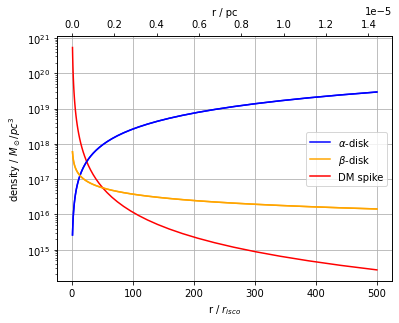

In [15]:
plt.figure(figsize=(6, 6 * 6./8.))
ax_risco = plt.gca()
ax_pc = ax_risco.twiny()

r_grid = np.geomspace(hs.r_isco, 500*hs.r_isco)
for disk, kwargs in [(alphaDisk, {"label":"$\\alpha$-disk", "color":colors["alpha"]}), (betaDisk, {"label":"$\\beta$-disk", "color":colors["beta"]})]:
    l, = ax_risco.plot(r_grid/hs.r_isco, disk.density(r_grid)/c.solar_mass_to_pc, label=kwargs["label"], color=kwargs["color"])
    ax_pc.plot(r_grid, disk.density(r_grid)/c.solar_mass_to_pc, color=l.get_c())

for spike, kwargs in sps_dm:
    l, = ax_risco.plot(r_grid/hs.r_isco, spike.density(r_grid)/c.solar_mass_to_pc, label=kwargs["label"], color=kwargs["color"])
    #ax_pc.plot(r_grid, sp.halo.density(r_grid)/ms.solar_mass_to_pc, color=l.get_c())
    
ax_pc.set_xlabel("r / pc"); ax_risco.set_xlabel("r / $r_{isco}$"); ax_risco.set_ylabel(r"density / $M_\odot/pc^3$")
ax_risco.set_yscale('log')
ax_risco.legend(); ax_risco.grid()
#plt.savefig("plots/rho_dm.pdf", bbox_inches="tight")#

### Relative Strength

(1e-19, 10.0)

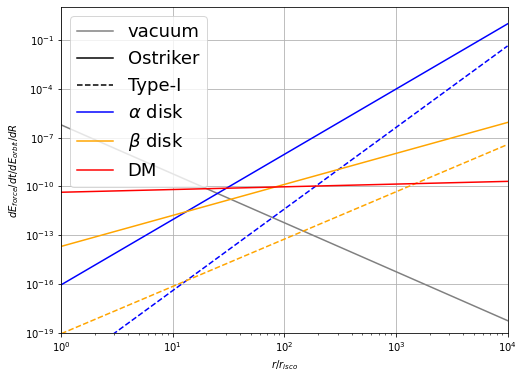

In [16]:
fig= plt.figure(figsize=(8,6))
r_grid = np.geomspace(hs.r_isco, 1e4*hs.r_isco, 100)
ax_risco = plt.gca()
#r_grid = np.geomspace(sp_0.r_isco(), 500*sp_0.r_isco())

kos = [KeplerOrbit(hs, m2, r, inclination_angle=np.pi) for r in r_grid]
ax_risco.loglog(r_grid/hs.r_isco, 
                [np.abs(forces.GWLoss().dE_dt(hs, ko, opt_0))/inspiral.Classic.dE_orbit_da(hs, ko) for ko in kos],
                label=r"GW", color=colors["vac"])

l1, = ax_risco.loglog(r_grid/hs.r_isco, 
                      [np.abs(gdf_alpha.dE_dt(hs, ko, opt=opt_gdf_alpha))/inspiral.Classic.dE_orbit_da(hs, ko) for ko in kos],
                                           label=r"Ostriker", color=colors["alpha"])
ax_risco.loglog(r_grid/hs.r_isco,
                    [np.abs(gi_alpha.dE_dt(hs, ko, opt=opt_gi_beta))/inspiral.Classic.dE_orbit_da(hs, ko) for ko in kos],
                                           label=r"Type I", color=l1.get_c(), linestyle='--')


l2, = ax_risco.loglog(r_grid/hs.r_isco, 
                      [np.abs(gdf_beta.dE_dt(hs, ko, opt=opt_gdf_beta))/inspiral.Classic.dE_orbit_da(hs, ko) for ko in kos],
                                        color=colors["beta"])
ax_risco.loglog(r_grid/hs.r_isco, 
                [np.abs(gi_beta.dE_dt(hs, ko, opt=opt_gi_beta))/inspiral.Classic.dE_orbit_da(hs, ko) for ko in kos],
                                              color=l2.get_c(), linestyle='--')

df = forces.DynamicalFriction(halo=spike, haloPhaseSpaceDescription=True, includeHigherVelocities=False)
opt_dm = inspiral.Classic.EvolutionOptions(dissipativeForces=[forces.GWLoss(), df], accuracy=accuracy, verbose=1)
plt.loglog(r_grid/hs.r_isco, 
               np.abs([df.dE_dt(hs, ko, opt=opt_dm)/inspiral.Classic.dE_orbit_da(hs, ko) for ko in kos]),
                                           label=r"DF", color=colors["dm"])

ax_risco.set_xlabel('$r/r_{isco}$'); ax_risco.set_ylabel("$dE_{force}/dt / dE_{orbit}/dR$")
explanatory_lines = [mpl.lines.Line2D([0], [0], color='gray'), 
                          mpl.lines.Line2D([0], [0], color='black'),
                          mpl.lines.Line2D([0], [0], color='black', linestyle='--'),
                          mpl.lines.Line2D([0], [0], color=colors["alpha"]),
                          mpl.lines.Line2D([0], [0], color=colors["beta"]), 
                          mpl.lines.Line2D([0], [0], color=colors["dm"]) ]
plt.legend(explanatory_lines, ['vacuum', 'Ostriker', 'Type-I', "$\\alpha$ disk", "$\\beta$ disk", "DM"], 
                               loc='upper left', fontsize=18) 
ax_risco.grid()

ax_risco.set_xlim(left=1, right=1e4); ax_risco.set_ylim(bottom=1e-19, top=1e1)
#plt.savefig("plots/dEdtdEdR.pdf", bbox_inches="tight")

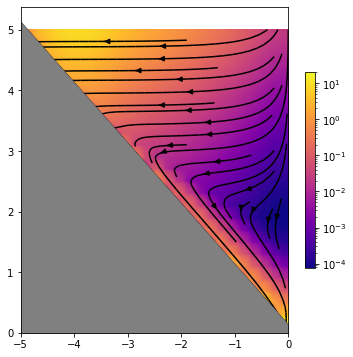

In [17]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
a_grid = np.geomspace(hs.r_isco, 1e5*hs.r_isco, 25)
e_grid = 1.-np.geomspace(1e-5, 1., 25)

opt_dm_b = inspiral.Classic.EvolutionOptions(dissipativeForces=[forces.GWLoss(), gdf_beta, df], 
                                             considerRelativeVelocities=True, accuracy=1e-8, verbose=1)

ko = KeplerOrbit(hs, m2, 0., inclination_angle=np.pi)

im = plot_utils.streamline(ax, hs, opt_dm_b, ko, a_grid, e_grid)
fig.colorbar(im, ax=ax, shrink=0.6)

### Inspiral

In [18]:
ad_models = [(alphaDisk, "Ostriker", {"label":"$\\alpha$-disk", "color":"purple"}), 
            (betaDisk, "Type-I", {"label":"$\\beta$-disk", "color":"green"}),
           ]
explanatory_lines = [mpl.lines.Line2D([0], [0], color='gray'),
                          mpl.lines.Line2D([0], [0], color=colors["dm"]),
                          mpl.lines.Line2D([0], [0], color="purple"),
                          mpl.lines.Line2D([0], [0], color="green"),
                          mpl.lines.Line2D([0], [0], color="black", linestyle='-.'),
                          mpl.lines.Line2D([0], [0], color="black"), 
                           ]
explanatory_labels = ["vacuum", "DM only", "Ostriker + $\\alpha$-disk", "Type-I + $\\beta$-disk", 
                      "Accretion disk w/o DM", "Accretion disk w/ DM"]


In [19]:
def preparePlots( figF, axesF, axes_ae=None, ax_m=None, axes_a=None, e_min=1e-5, f_min=1e-5, n_b_min=-2.):
    figF.subplots_adjust(hspace=0, wspace=0)
    
    if not axes_ae is None:
        for ax in axes_ae:
            ax.set_xlabel('semimajor axis / $r_{isco}$')
            ax.grid()
        axes_ae[0].set_ylabel('eccentricity')

    if not axes_a is None:
        for ax in axes_a:
            ax.set_xlabel('time / yr')
            ax.grid()
        axes_a[0].set_ylabel('semimajor axis / $r_{isco}$')
        #axes_a[-1].legend(loc='upper left', bbox_to_anchor=(0.9, 1.))
    
    axesF[0,0].set_ylabel(r'$|\Delta N|$')
    axesF[1,0].set_ylabel(r'dephasing index')
    axesF[2,0].set_ylabel(r'braking index')
    

    for ax in axesF[-1,:]:
        ax.set_xlabel('frequency / Hz')

    if axes_a is None and axes_ae is None:
        axesF[1,-1].legend(loc='lower left', bbox_to_anchor=(0.9, 1.))
    
    axesF[0,0].set_xlim(left=f_min)
    axesF[0,0].set_ylim(bottom=1., top=1e10)
    axesF[1,0].set_ylim(bottom=-8, top=0)
    axesF[2,0].set_ylim(bottom=n_b_min, top=5)

    for ax in axesF.flatten():
        ax.grid()

In [20]:
def compareModels(hs, spike, ad_models, k0, fudge_factor=1., a_fin=0.,
                  ax_a=None, ax_e=None, ax_ae=None, ax_h=None, ax_dN2=None, ax_ddN2=None, ax_n=None,
                  acc=1e-10):
    
    opt_0 = inspiral.Classic.EvolutionOptions(dissipativeForces=[forces.GWLoss()], accuracy=acc, verbose=1)
    df = forces.DynamicalFriction(halo=spike, haloPhaseSpaceDescription=True, includeHigherVelocities=False)
    opt_dm = inspiral.Classic.EvolutionOptions(dissipativeForces=[forces.GWLoss(), df], accuracy=acc, verbose=1)

    ev_0 = inspiral.Classic.Evolve(hs, k0, opt=opt_0)
    ev_dm = inspiral.Classic.Evolve(hs, k0, opt=opt_dm)   
    
    l = plot_utils.plotEvolution(hs, ev_0, ax_a=ax_a, ax_ae=ax_ae, ax_n=ax_n, label='vacuum')

    l = plot_utils.plotEvolution(hs, ev_dm, ax_a=ax_a, ax_ae=ax_ae, ax_n=ax_n, label='spike', color=colors["dm"])
    plot_utils.plotDeltaN(hs, ev_0, ev_dm, ax_dN2, color=l.get_c(), label='spike')
    
    for disk, t, kwargs in ad_models:
        if t == "Ostriker":
            gas_df = forces.GasDynamicalFriction(disk=disk)
        else:
            gas_df = forces.GasInteraction(disk=disk)

        opt_b = inspiral.Classic.EvolutionOptions(dissipativeForces=[forces.GWLoss(), gas_df], 
                                         considerRelativeVelocities=True, accuracy=acc, verbose=1)
        opt_dm_b = inspiral.Classic.EvolutionOptions(dissipativeForces=[forces.GWLoss(), gas_df, df], 
                                         considerRelativeVelocities=True, accuracy=acc, verbose=1)
        
        ev_b = inspiral.Classic.Evolve(hs, k0, opt=opt_b)
        ev_dm_b = inspiral.Classic.Evolve(hs, k0, opt=opt_dm_b)
        
        l = plot_utils.plotEvolution(hs, ev_b, ax_a=ax_a, ax_ae=ax_ae, ax_n=ax_n, **kwargs, linestyle='-.')
        plot_utils.plotDeltaN(hs, ev_0, ev_b, ax_dN2, ax_di=ax_ddN2, plotFgw5year=True, **kwargs, linestyle='-.')

        plot_utils.plotEvolution(hs, ev_dm_b, ax_a=ax_a, ax_ae=ax_ae, ax_n=ax_n, **kwargs)
        plot_utils.plotDeltaN(hs, ev_0, ev_dm_b, ax_dN2, ax_di=ax_ddN2, **kwargs)


#### Example

Evolving from  500.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, }, accuracy = 1.0e-13
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 0.0971s real time
Evolving from  500.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-13
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 0.4926s real time
Evolving from  500.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, GasDynamicalFriction, }, accuracy = 1.0e-13
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 0.7845s real time
Evolving from  500.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, GasDynamicalFriction, DynamicalFriction, }, accuracy = 1.0e-13


/media/data/Documents/PhD/imripy/src/imripy/merger_system.py:102: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.mass(r)/r**3)
/media/data/Documents/PhD/imripy/src/imripy/kepler.py:240: RuntimeWarning: invalid value encountered in sqrt
  v = np.sqrt(self.m_tot *(2./r - 1./self.a))
/media/data/Documents/PhD/imripy/src/imripy/halo/dm.py:147: RuntimeWarning: invalid value encountered in double_scalars
  return np.where(r > self.r_min, self.rho_spike * (self.r_spike/r)**self.alpha, 0.)


A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 1.9616s real time
Evolving from  500.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, GasInteraction, }, accuracy = 1.0e-13
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 0.2508s real time
Evolving from  500.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, GasInteraction, DynamicalFriction, }, accuracy = 1.0e-13
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 1.1535s real time


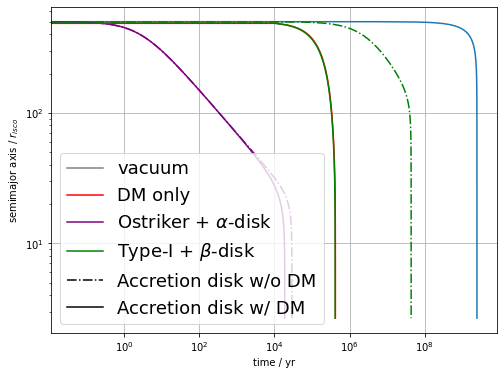

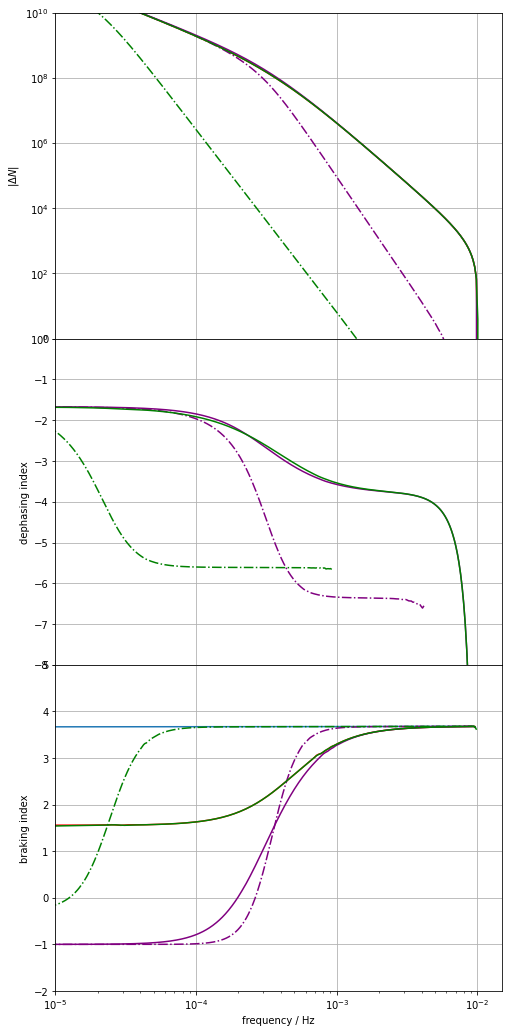

In [21]:
# An example case
figT, axes_ae = plt.subplots(1, 1, figsize=(8,6))
figF, axes_gw = plt.subplots(3, 1, sharex='col', figsize=(8,18))

# Set initial conditions for orbital evolution
a0 = 500 * hs.r_isco
e0 = 0.
k0 = KeplerOrbit(hs, m2, a0, e0, inclination_angle=np.pi)

compareModels(hs, sps_dm[0][0], ad_models, k0, acc=1e-13,
                      ax_a=axes_ae,  ax_dN2=axes_gw[0], ax_ddN2=axes_gw[1], ax_n=axes_gw[2])

preparePlots(figF, np.array([ [axes_gw[0]], [axes_gw[1]], [axes_gw[2]] ]), axes_a=[axes_ae])

#axes_ae[1].set_yscale('log')
axes_ae.legend(explanatory_lines, explanatory_labels, loc='lower left', fontsize=18) 
#figT.savefig("plots/evolution_example.pdf", bbox_inches="tight"); figF.savefig("plots/gwSignal_example.pdf", bbox_inches="tight")

#### Varying intial ecccentricity

Evolving from  500.0  to  1.0 r_isco  with initial eccentricity 0.0001  with  Options: dissipative forces employed {GWLoss, }, accuracy = 1.0e-12
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 0.0884s real time
Evolving from  500.0  to  1.0 r_isco  with initial eccentricity 0.0001  with  Options: dissipative forces employed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-12
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 12.0506s real time
Evolving from  500.0  to  1.0 r_isco  with initial eccentricity 0.0001  with  Options: dissipative forces employed {GWLoss, GasDynamicalFriction, }, accuracy = 1.0e-12


/media/data/Documents/PhD/imripy/src/imripy/inspiral/forces.py:80: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return -(1.-e**2)**(3./2.)/2./np.pi * quad(integrand, 0., 2.*np.pi, limit = 100)[0]
/media/data/Documents/PhD/imripy/src/imripy/inspiral/forces.py:370: RuntimeWarning: invalid value encountered in double_scalars
  return -32./5. * ko.m_red**2 * ko.m_tot**(5./2.) / ko.a**(7./2.)  / (1. - ko.e**2)**2 * (1. + 7./8.*ko.e**2)
/media/data/Documents/PhD/imripy/src/imripy/inspiral/forces.py:105: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return -(1.-e**2)**(3./2.)/2./np.pi * quad(integrand, 0., 2.*np.pi, limit = 100)[0]
/media/data/Documents/PhD/imripy/src/imripy/inspiral/classic.py:139: RuntimeWarning: invalid value encountered in sqrt
  L

A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 21.4951s real time
Evolving from  500.0  to  1.0 r_isco  with initial eccentricity 0.0001  with  Options: dissipative forces employed {GWLoss, GasDynamicalFriction, DynamicalFriction, }, accuracy = 1.0e-12


/media/data/Documents/PhD/imripy/src/imripy/inspiral/forces.py:241: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return -(1.-e**2)**(3./2.)/2./np.pi * quad(integrand, 0., 2.*np.pi, limit = 100)[0]
/media/data/Documents/PhD/imripy/src/imripy/inspiral/forces.py:264: RuntimeWarning: invalid value encountered in sqrt
  return -(1.-e**2)**(3./2.)/2./np.pi *np.sqrt(ko.m_tot * a*(1.-e**2))* quad(integrand, 0., 2.*np.pi, limit = 100)[0]
/media/data/Documents/PhD/imripy/src/imripy/inspiral/forces.py:264: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return -(1.-e**2)**(3./2.)/2./np.pi *np.sqrt(ko.m_tot * a*(1.-e**2))* quad(integrand, 0., 2.*np.pi, limit = 100)[0]


A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 51.9264s real time
Evolving from  500.0  to  1.0 r_isco  with initial eccentricity 0.0001  with  Options: dissipative forces employed {GWLoss, GasInteraction, }, accuracy = 1.0e-12
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 2.1337s real time
Evolving from  500.0  to  1.0 r_isco  with initial eccentricity 0.0001  with  Options: dissipative forces employed {GWLoss, GasInteraction, DynamicalFriction, }, accuracy = 1.0e-12
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 13.6454s real time
Evolving from  500.0  to  1.0 r_isco  with initial eccentricity 0.01  with  Options: dissipative forces employed {GWLoss, }, accuracy = 1.0e-11
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 0.0607s real time
Evolving from  500.0  to  1.0 r_isco  with initial eccentricity 0.01  with  Options: dissipative forces employed {GWLoss, DynamicalFriction

/media/data/Documents/PhD/imripy/src/imripy/halo/baryonic.py:543: RuntimeWarning: invalid value encountered in double_scalars
  * (self.M / 1e6 / c.solar_mass_to_pc)**(1./5.) * (r / 10./self.M)**(-3./5.)),


A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 12.8735s real time


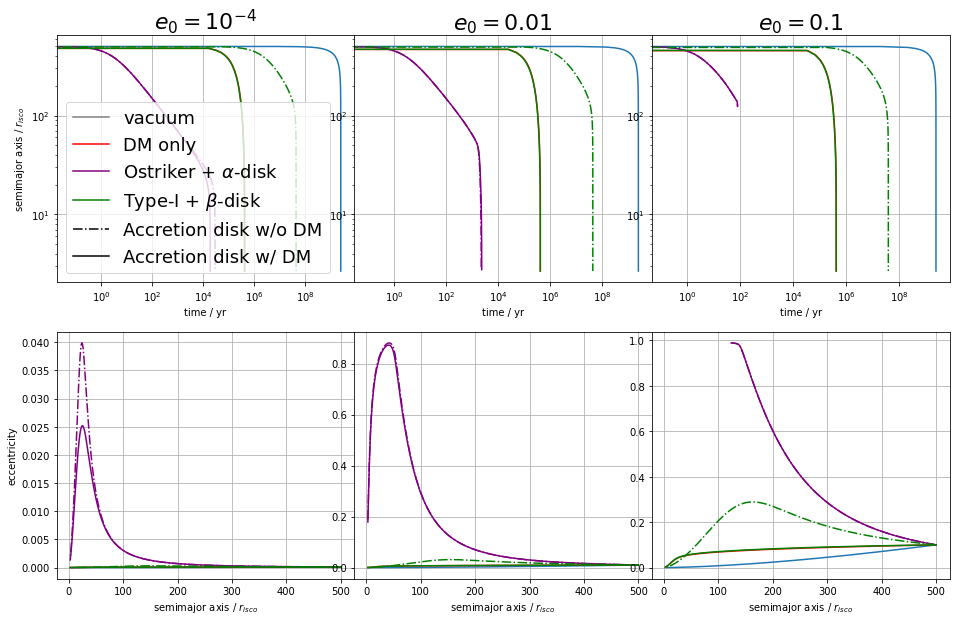

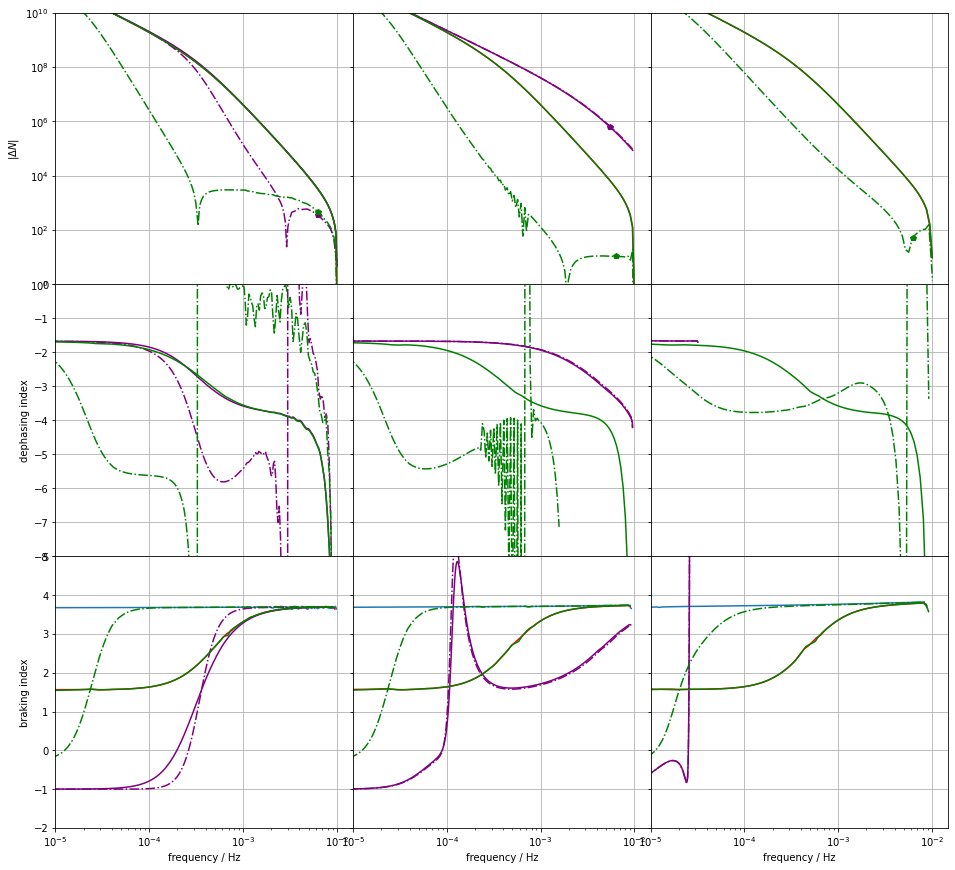

In [22]:
# Look at different initial eccentricities
figT, axesT = plt.subplots(2, 3, figsize=(16, 10))
figF, axesF = plt.subplots(3, 3, figsize=(16, 15), sharex='all', sharey='row')
# Set initial conditions for orbital evolution
a0 = 500 * hs.r_isco
k0 = KeplerOrbit(hs, m2, a0, inclination_angle=np.pi)

k0.e = 1e-4
axesT[0,0].set_title(r"$e_0=10^{-4}$", fontsize=22);# axesF[0,0].set_title(r"$e_0=10^{-4}$")
compareModels(hs, spike, ad_models, k0, acc=1e-12,
              ax_a=axesT[0,0], ax_ae=axesT[1,0], ax_dN2=axesF[0,0], ax_ddN2=axesF[1,0], ax_n=axesF[2,0])
k0.e = 0.01
axesT[0,1].set_title(r"$e_0=0.01$", fontsize=22);# axesF[0,1].set_title(r"$e_0=0.1$")
compareModels(hs, spike, ad_models, k0, acc=1e-11,
              ax_a=axesT[0,1], ax_ae=axesT[1,1], ax_dN2=axesF[0,1], ax_ddN2=axesF[1,1], ax_n=axesF[2,1])
k0.e = 0.1
axesT[0,2].set_title(r"$e_0=0.1$", fontsize=22); #axesF[0,2].set_title(r"$e_0=0.6$")
compareModels(hs, sps_dm[0][0], ad_models, k0, acc=1e-10,
              ax_a=axesT[0,2], ax_ae=axesT[1,2], ax_dN2=axesF[0,2], ax_ddN2=axesF[1,2], ax_n=axesF[2,2])

preparePlots( figF, axesF, axes_ae = axesT[1,:], axes_a=axesT[0,:])
figT.subplots_adjust(wspace=0)
axesT[0,0].legend(explanatory_lines, explanatory_labels, loc='lower left', fontsize=18) 
axesT[0,0].set_yscale('log')
#figT.savefig("plots/evolution_e0.pdf", bbox_inches="tight"); figF.savefig("plots/gwSignal_e0.pdf", bbox_inches="tight")

#### Varying central mass

Evolving from  500.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, }, accuracy = 1.0e-12
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 0.0636s real time
Evolving from  500.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-12
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 0.4289s real time
Evolving from  500.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, GasDynamicalFriction, }, accuracy = 1.0e-12
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 0.5133s real time
Evolving from  500.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, GasDynamicalFriction, DynamicalFriction, }, accuracy = 1.0e-12
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 1.1688s real time
Evolving from 

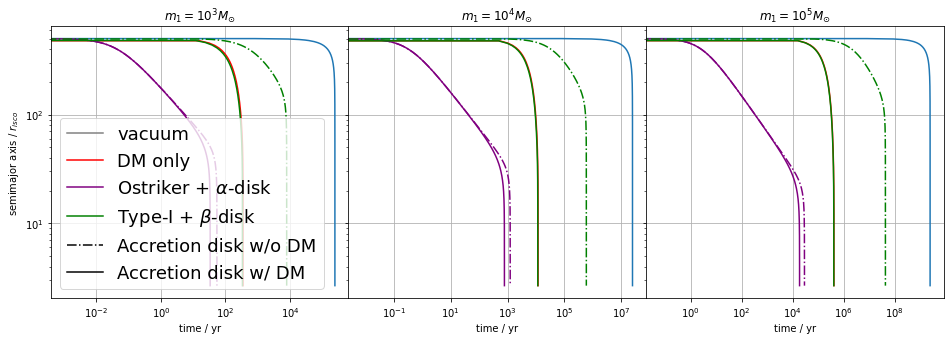

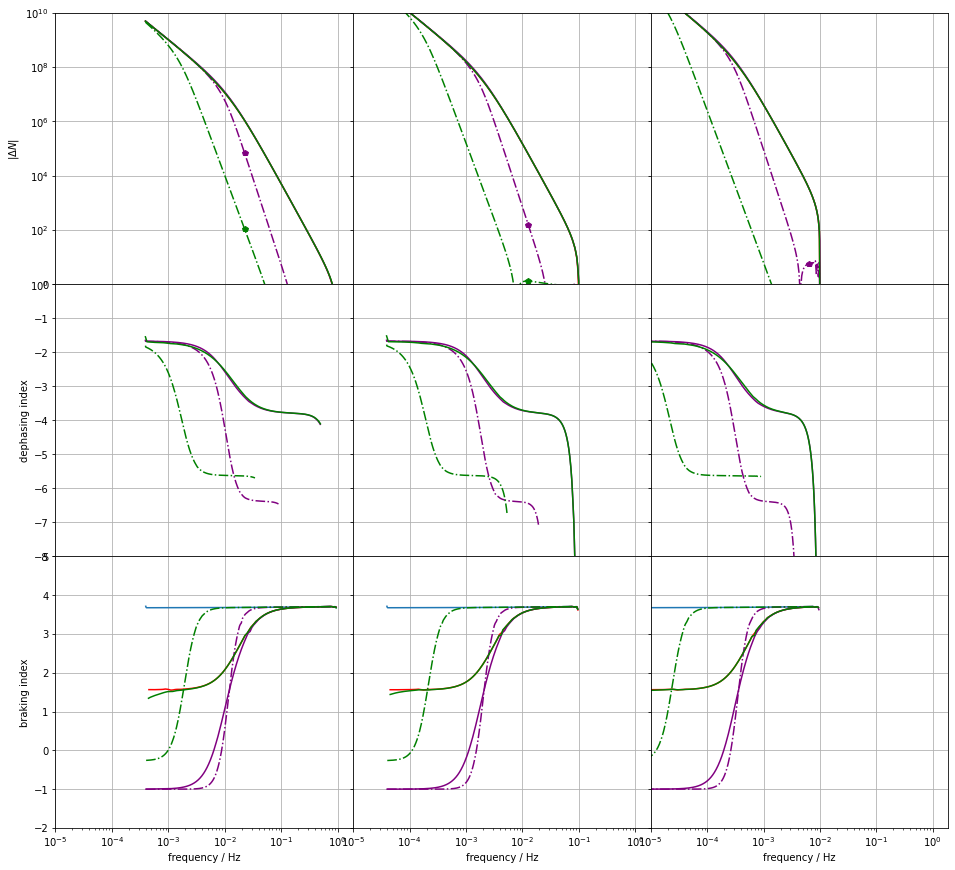

In [23]:
# Look at different m1
figT, axesT = plt.subplots(1, 3, figsize=(16,5), sharey='row')
figF, axesF = plt.subplots(3, 3, figsize=(16,15), sharex='all', sharey='row')

e0 = 0.

# 1
rho6 = 5.448e15 * c.solar_mass_to_pc
m1 = 1e3 * c.solar_mass_to_pc
hs_1 = ms.HostSystem(m1, D_l=D)
spike_1 = halo.Spike.FromRho6(rho6, m1, g_spike)
ad_models_1 = [(halo.AlphaDisk(m1, alpha, f_edd, eps), "Ostriker", {"label":"alphaDisc", "color":"purple"}), 
                (halo.BetaDisk(m1, alpha, f_edd, eps), "Type-I", {"label":"betaDisc", "color":"green"})]
a0 = 5e2*hs_1.r_isco
k0_1 = KeplerOrbit(hs_1, m2, a0, e0, inclination_angle=np.pi)
axesT[0].set_title(r"$m_1 = 10^3 M_{\odot}$"); #axesF[0,0].set_title(r"$m_1 = 10^3 M_{\odot}$")
compareModels(hs_1, spike_1, ad_models_1, k0_1,
              ax_a=axesT[0], ax_dN2=axesF[0,0], ax_ddN2=axesF[1,0], ax_n=axesF[2,0], acc=1e-12)

# 2
m1 = 1e4 * c.solar_mass_to_pc
rho6 = rho6 = 5.448e15 * 5. * c.solar_mass_to_pc
hs_2 = ms.HostSystem(m1, D_l=D)
spike_2 = halo.Spike.FromRho6(rho6, m1, g_spike)
ad_models_2 = [(halo.AlphaDisk(m1, alpha, f_edd, eps), "Ostriker", {"label":"alphaDisc", "color":"purple"}), 
                (halo.BetaDisk(m1, alpha, f_edd, eps), "Type-I", {"label":"betaDisc", "color":"green"})]
a0 = 5e2*hs_2.r_isco
k0_2 = KeplerOrbit(hs_2, m2, a0, e0, inclination_angle=np.pi)
axesT[1].set_title(r"$m_1 = 10^4 M_{\odot}$"); #axesF[0,1].set_title(r"$m_1 = 10^4 M_{\odot}$")
compareModels(hs_2, spike_2, ad_models_2, k0_2,
              ax_a=axesT[1], ax_dN2=axesF[0,1], ax_ddN2=axesF[1,1], ax_n=axesF[2,1], acc=1e-12)
# 3
m1 = 1e5 * c.solar_mass_to_pc
rho6 = rho6 = 5.448e15 * 5.**2 * c.solar_mass_to_pc
hs_3 = ms.HostSystem(m1, D_l=D)
spike_3 = halo.Spike.FromRho6(rho6, m1, g_spike)
ad_models_3 = [(halo.AlphaDisk(m1, alpha, f_edd, eps), "Ostriker", {"label":"alphaDisc", "color":"purple"}), 
                (halo.BetaDisk(m1, alpha, f_edd, eps), "Type-I", {"label":"betaDisc", "color":"green"})]
a0 = 5e2*hs_3.r_isco
k0_3 = KeplerOrbit(hs_3, m2, a0, e0, inclination_angle=np.pi)
axesT[2].set_title(r"$m_1 = 10^5 M_{\odot}$"); #axesF[0,2].set_title(r"$m_1 = 10^5 M_{\odot}$")
compareModels(hs_3, spike_3, ad_models_3, k0_3,
              ax_a=axesT[2], ax_dN2=axesF[0,2], ax_ddN2=axesF[1,2], ax_n=axesF[2,2], acc=1e-12)

preparePlots(figF, axesF, axes_a=axesT)
axesT[0].legend(explanatory_lines, explanatory_labels, loc='lower left', fontsize=18) 
figT.subplots_adjust(wspace=0)
#figT.savefig("plots/evolution_m1.pdf", bbox_inches="tight"); figF.savefig("plots/gwSignal_m1.pdf", bbox_inches="tight")